In [395]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets

plt.style.use(["science","bright","grid"])

from scipy.optimize import curve_fit, lsq_linear, least_squares
from scipy.signal import TransferFunction, lsim
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def sin_func(t, A, f0, phi, B):
    return A*np.sin(2*np.pi*f0*t-phi) + B

def exp_decay(x, a, b, c):
    return a*np.exp(-x/b) + c

### Load the data

In [201]:
N_periods   = 40
U0          = 0.1
amplitudes  = [U0,0.0]
Np          = 9
N_eq_p      = 10
np_idx      = [4+9*i for i in range(9)]

topology_parameter      = {
    "Nx"                : Np,
    "Ny"                : Np,
    "Nz"                : 1,
    "e_pos"             : [[(Np-1)//2,0,0],[(Np-1)//2,Np-1,0]],
    "electrode_type"    : ['constant','floating']
}

folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/ac_input_vs_freq/"
freq_vals   = [0.001,0.002,0.004,0.006,0.008,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.]
time_data   = {}
U0_data     = {}
data        = {}
pot_data    = {}
dt_vals     = {}

for i in range(len(freq_vals)):
    f0                  = freq_vals[i]*1e6      # Convert MHz to Hz
    dt                  = 1/(40 * f0)           # 20 Samples per period
    T_sim               = N_periods/f0
    N_voltages          = int(T_sim/dt)
    frequencies         = [f0,0.0]
    amplitudes          = [0.1,0.0]
    time_steps, volt    = nanonets_utils.sinusoidal_voltages(N_voltages, topology_parameter,
                                                                amplitudes=amplitudes,
                                                                frequencies=frequencies,
                                                                time_step=dt)
    N_volt              = len(time_steps)
    data[f0/1e6]        = pd.read_csv(f"{folder}Nx={Np}_Ny={Np}_Nz=1_Ne=2_{f0/1e6}.csv").iloc[N_eq_p*N_volt//N_periods:,:].reset_index(drop=True)
    pot_data[f0/1e6]    = pd.read_csv(f"{folder}mean_state_Nx={Np}_Ny={Np}_Nz=1_Ne=2_{f0/1e6}.csv").iloc[N_eq_p*N_volt//N_periods:,:].reset_index(drop=True)
    time_data[f0/1e6]   = time_steps[:len(data[f0/1e6])]*1e9
    U0_data[f0/1e6]     = volt[N_eq_p*N_volt//N_periods:-1,0]
    dt_vals[f0/1e6]     = dt

In [202]:
# rel_error   = pd.DataFrame([np.abs(data[f0]['Error'].values)*1000 for f0 in freq_vals], index=freq_vals).T
# rel_error   = rel_error.replace(0.0, np.nan)

# fig = plt.figure(dpi=200)
# fig.set_figwidth(fig.get_figwidth()*2.5)
# ax  = fig.add_subplot()
# ax  = sns.boxplot(rel_error, log_scale=True, color=nanonets_utils.blue_color)
# # ax.set_ylim(0.0001,1)
# # ax.set_ylim(0,0.4)
# ax.set_ylabel("$\epsilon$ [mV]")
# ax.set_xlabel("$f_0$ [MHz]")
# _ = plt.xticks(rotation=45)

### Relative Error

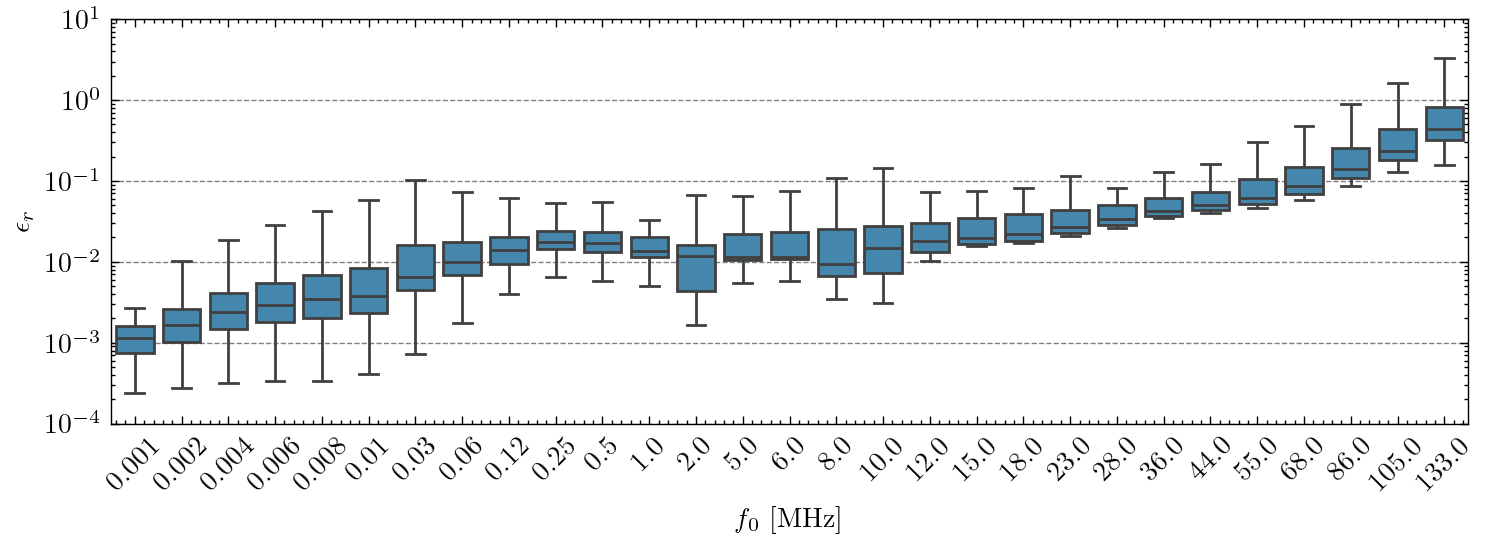

In [203]:
rel_error   = pd.DataFrame([np.abs(data[f0]['Error'].values/data[f0]['Current'].values) for f0 in freq_vals], index=freq_vals).T
rel_error   = rel_error.replace([np.inf,1.0,0.0,0.5], np.nan)

fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.5)
ax  = fig.add_subplot()
ax  = sns.boxplot(rel_error, log_scale=True, color=nanonets_utils.blue_color, fliersize=0)
ax.set_ylim(0.0001,10)
ax.set_ylabel("$\epsilon_r$")
ax.set_xlabel("$f_0$ [MHz]")
_ = plt.xticks(rotation=45)

fig.savefig("../plots/ac_input/2_electrodes/rel_error.svg", transparent=True)

### NPs on the line between Input - Output

Text(0.5, 1.0, '$f_0 = 0.001$ MHz')

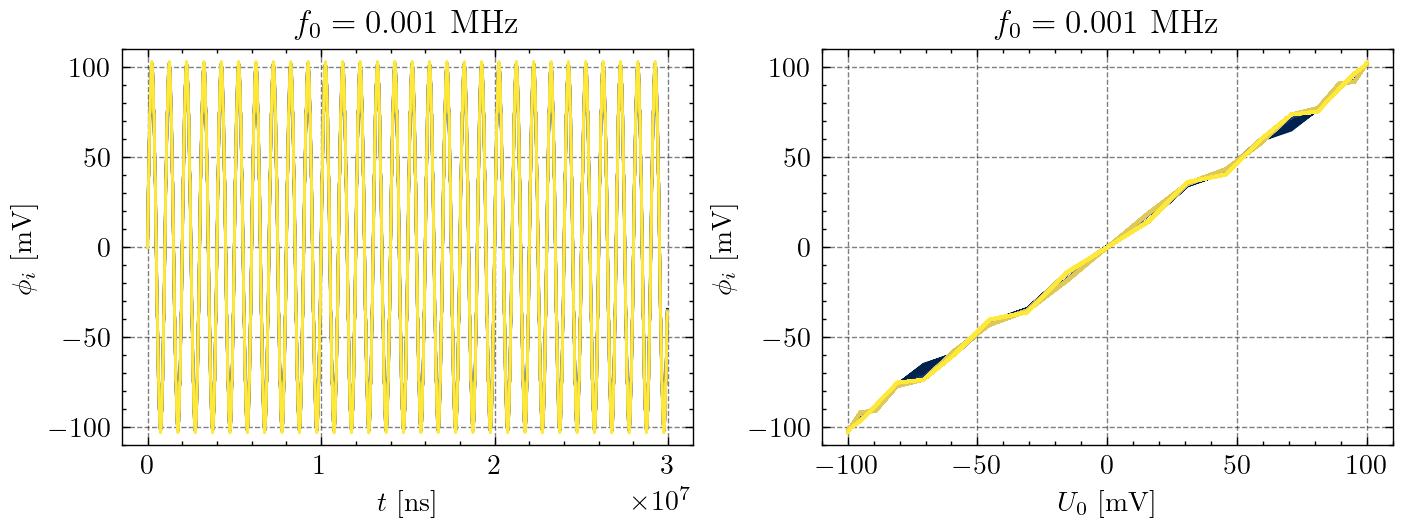

In [204]:
f0      = 0.001
pot     = pot_data[f0].copy()*1000
np_idx  = [4+9*i for i in range(9)]
norm    = Normalize(vmin=min(np_idx), vmax=max(np_idx))

cm      = plt.get_cmap('cividis')
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
ax      = fig.add_subplot(1,2,1)

for i in np_idx:
    ax.plot(time_data[f0], pot.iloc[:,i], color=cm(norm(i)))

ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$\phi_i$ [mV]")
ax.set_ylim(-110,110)
ax.set_title(f"$f_0 = {f0}$ MHz")

ax      = fig.add_subplot(1,2,2)

for i in np_idx:
    ax.plot(U0_data[f0]*1000, pot.iloc[:,i], color=cm(norm(i)))

ax.set_xlabel("$U_0$ [mV]")
ax.set_ylabel("$\phi_i$ [mV]")
ax.set_xlim(-110,110)
ax.set_ylim(-110,110)
ax.set_title(f"$f_0 = {f0}$ MHz")

In [205]:
params_main = []
for f0 in freq_vals:
    pot     = pot_data[f0].copy()*1000
    np_idx  = [4+9*i for i in range(9)]
    params  = []

    def sin_func(t, A, phi):
        return A*np.sin(2*np.pi*f0*1e6*t-phi)
    for i in np_idx:
        p,_ = curve_fit(sin_func, time_data[f0]*1e-9, pot.iloc[:,i], p0=[50,0.0], bounds=((0,-2*np.pi),(100,2*np.pi)))
        params.append(p)
    params_main.append(params)
    
params_main  = np.array(params_main)

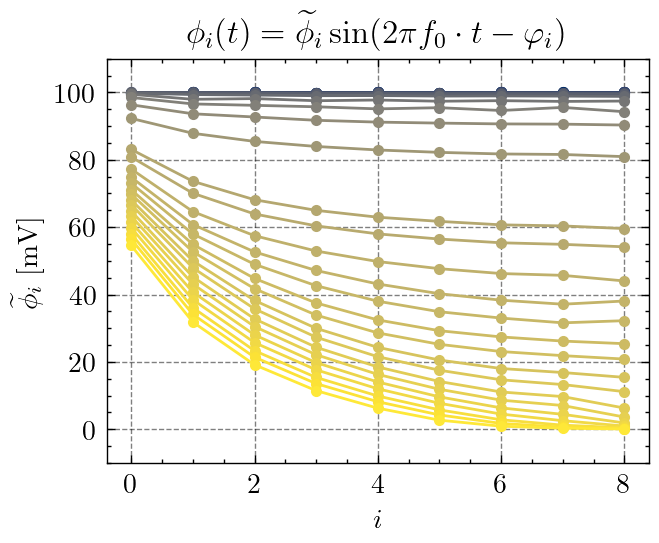

In [206]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = LogNorm(vmin=min(freq_vals), vmax=max(freq_vals))

for i, params in enumerate(params_main):
    ax.plot(params[:,0], label='$f_0 = {f0}$ MHz', color=cm(norm(freq_vals[i])), marker='.')

ax.set_xlabel("$i$")
ax.set_ylabel("$\\widetilde{\phi}_i$ [mV]")
ax.set_title("$\phi_i(t) = \\widetilde{\phi}_i\sin(2\pi f_0 \cdot t- \\varphi_i)$")
# ax.set_yscale('log')
ax.set_ylim(-10,110)
fig.savefig("../plots/ac_input/2_electrodes/amplitude_along_the_line.svg", transparent=True)

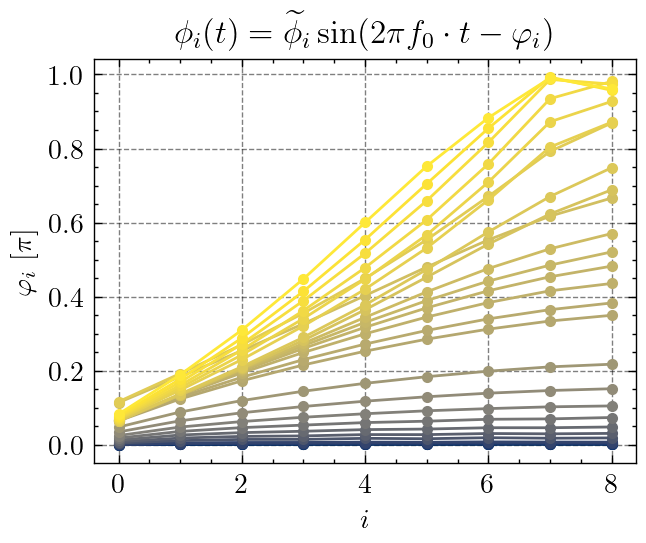

In [207]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = LogNorm(vmin=min(freq_vals), vmax=max(freq_vals))

for i, params in enumerate(params_main):
    vals            = ((params[:,1].copy()+np.pi)%(2*np.pi)-np.pi)/np.pi
    ax.plot(np.abs(vals), label='$f_0 = {f0}$ MHz', color=cm(norm(freq_vals[i])), marker='.')

ax.set_xlabel("$i$")
ax.set_ylabel("$\\varphi_i$ [$\pi$]")
ax.set_title("$\phi_i(t) = \\widetilde{\phi}_i\sin(2\pi f_0 \cdot t- \\varphi_i)$")
fig.savefig("../plots/ac_input/2_electrodes/phase_along_the_line.svg", transparent=True)

### System Characterization

In [208]:
N_f         = 18    # Number of Frequency for Harmonic Strength
h_strength  = []    # Storage for Harmonic Strength
thd         = []    # Total Harmonic Distortion
A_f0        = []    # FFT Amplitude of f0
phase       = []    # Phase Shift
f0_th       = 0.9
thd_out     = []

for f0 in freq_vals:

    h1  = []
    t1  = []
    A1  = []
    p1  = []
    def sin_func(t, A, phi):
        return A*np.sin(2*np.pi*f0*1e6*t-phi)
    
    for i in range(Np*Np):
        t_val   = time_data[f0]*1e-9
        y_val   = pot_data[f0].iloc[:,i].values.copy()*1000
        h_temp  = nanonets_utils.harmonic_strength(signal=y_val, f0=f0*1e6, dt=dt_vals[f0], N_f=N_f,
                                                   n_padded=len(y_val)*10, dB=False, sigma_threshold=0, use_hann=False)
        xf,yf   = nanonets_utils.fft(y_val, dt_vals[f0], n_padded=len(y_val)*10, use_hann=False)
        func    = interp1d(xf, yf)
        A2      = float(func(f0*1e6))
        p,_     = curve_fit(sin_func, t_val, y_val, bounds=((0,0),(100,np.inf)))

        h1.append(h_temp)
        t1.append(np.sqrt(np.sum(np.array(h_temp)**2))*100)
        A1.append(A2)
        p1.append(((p[1]+np.pi)%(2*np.pi)-np.pi)/np.pi)

    y_out   = data[f0]['Current'].values.copy()*1000
    h_out   = nanonets_utils.harmonic_strength(signal=y_out, f0=f0*1e6, dt=dt_vals[f0], N_f=N_f,
                                               n_padded=len(y_out)*10, dB=False, sigma_threshold=0, use_hann=False)
    thd_out.append(np.sqrt(np.sum(np.array(h_out)**2))*100)
    A_f0.append(A1)
    h_strength.append(h1)
    thd.append(t1)
    phase.append(p1)

thd_df  = pd.DataFrame(thd, index=np.round(np.array(freq_vals),4))
A_f0_df = pd.DataFrame(A_f0, index=np.round(np.array(freq_vals),4))
pha_df  = pd.DataFrame(phase, index=np.round(np.array(freq_vals),4))

In [209]:
# np.save("../../paper/data/thd_vals_C_10.npy", thd_df)
# np.save("../../paper/data/amplitude_C_10.npy", A_f0_df)
# np.save("../../paper/data/phase_C_10.npy", pha_df)
# np.save("../../paper/data/thd_out_C_10.npy", thd_out)

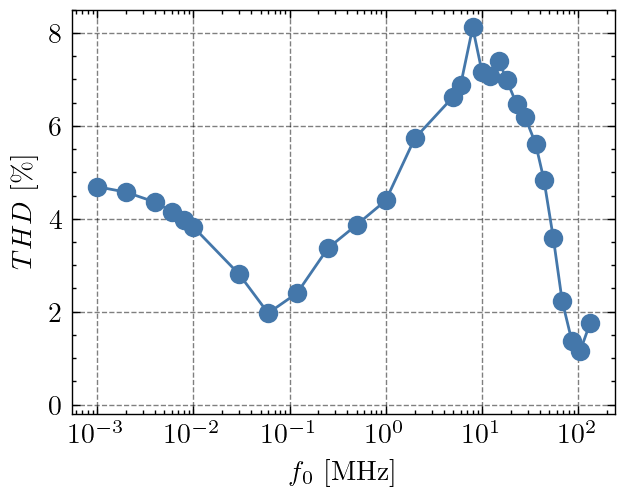

In [210]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(freq_vals, thd_out, 'o-')
ax.set_ylabel('$THD$ [\%]')
ax.set_xlabel('$f_0$ [MHz]')
ax.set_xscale('log')
ax.set_ylim(-0.2,8.5)
fig.savefig("../plots/ac_input/2_electrodes/thd_output_vs_freq.svg", transparent=True)

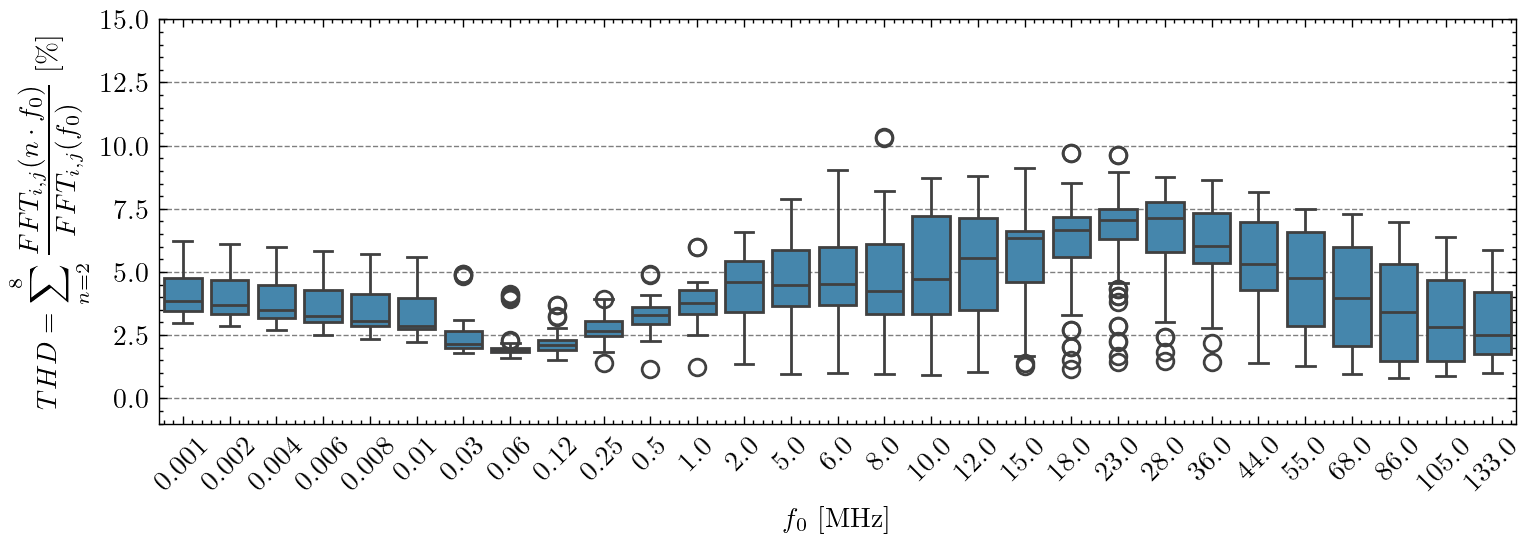

In [211]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.5)
ax  = fig.add_subplot()
ax  = sns.boxplot(thd_df.T, log_scale=False, color=nanonets_utils.blue_color)
ax.set_ylim(0,10)
ax.set_ylabel("$THD = \displaystyle\sum_{n=2}^{8}\\frac{FFT_{i,j}(n \cdot f_0)}{FFT_{i,j}(f_0)}$ [\%]")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylim(-1,15)
_ = plt.xticks(rotation=45)
fig.savefig("../plots/ac_input/2_electrodes/thd_dists_vs_freq.svg", transparent=True)

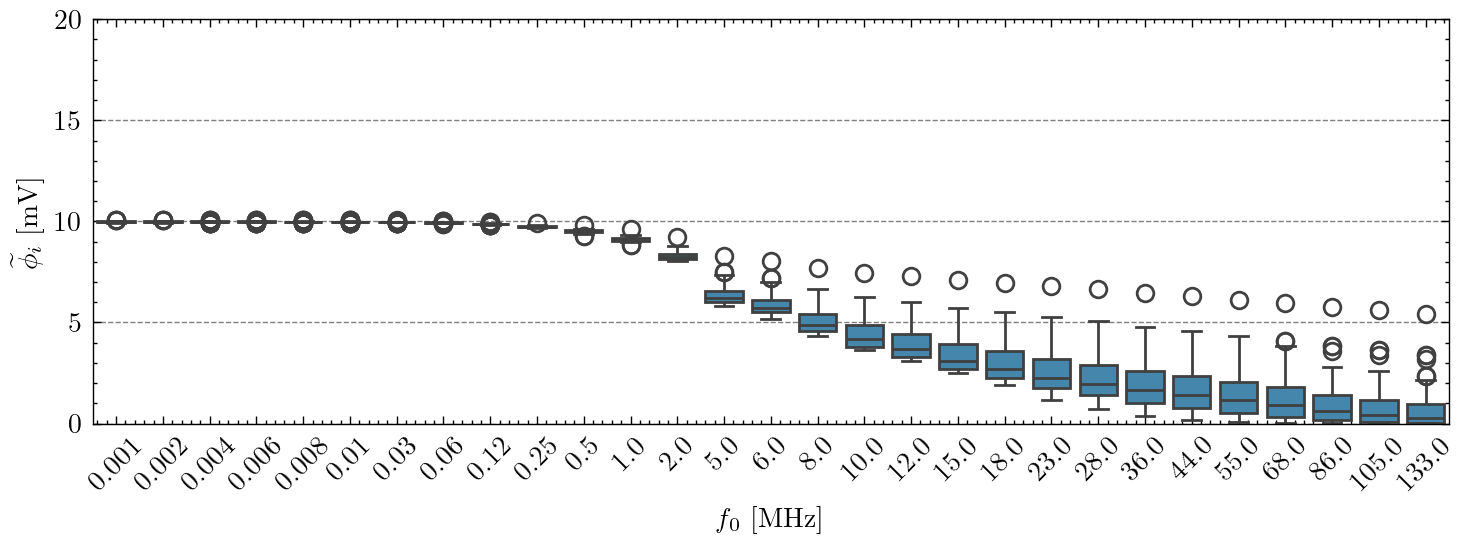

In [212]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.5)
ax  = fig.add_subplot()
ax  = sns.boxplot(A_f0_df.T, log_scale=False, color=nanonets_utils.blue_color)
# ax.set_ylim(0,10)
ax.set_ylabel("$\\widetilde{\phi}_i$ [mV]")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylim(0,20)
_ = plt.xticks(rotation=45)
fig.savefig("../plots/ac_input/2_electrodes/amplitude_dist_vs_freq.svg", transparent=True)

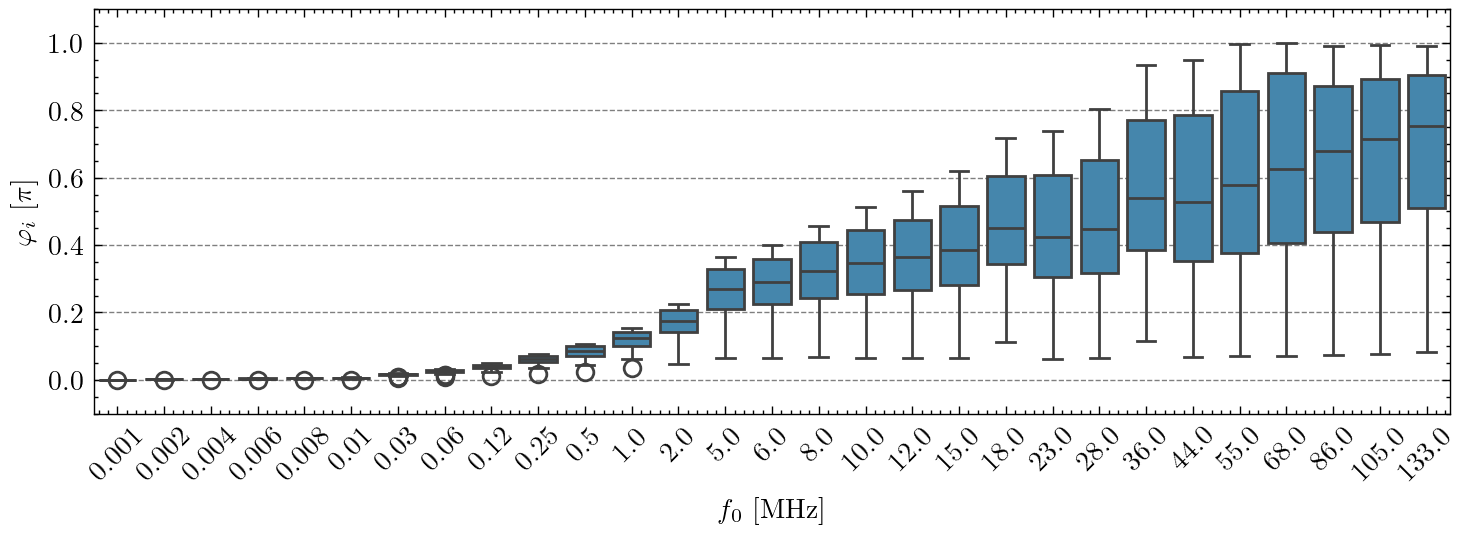

In [213]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.5)
ax  = fig.add_subplot()
ax  = sns.boxplot(np.abs(pha_df.T), log_scale=False, color=nanonets_utils.blue_color)
# ax.set_ylim(0,10)
ax.set_ylabel("$\\varphi_i$ [$\pi$]")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylim(-0.1,1.1)
_ = plt.xticks(rotation=45)
fig.savefig("../plots/ac_input/2_electrodes/phase_dist_vs_freq.svg", transparent=True)

### Output Characterization

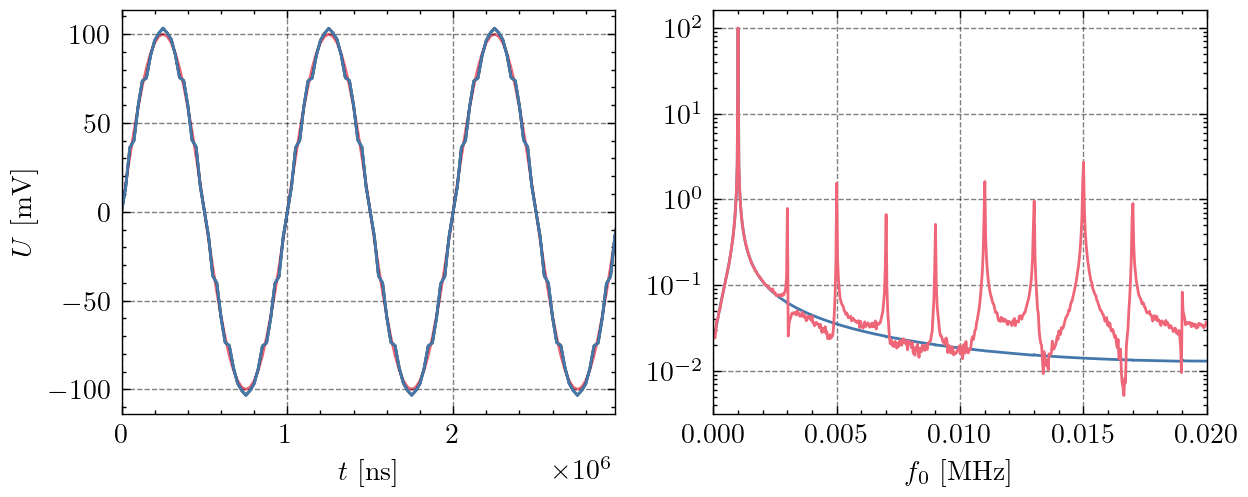

In [488]:
f0  = 0.001
t_v = time_data[f0]
x_v = data[f0]['E0'].values*1000
y_v = data[f0]['Current'].values*1000
y_e = data[f0]['Error'].values*1000

fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.0)

ax  = fig.add_subplot(1,2,1)
ax.plot(t_v,y_v)
ax.fill_between(t_v,y_v-y_e,y_v+y_e,color='black',alpha=0.5)
ax.plot(t_v, x_v,zorder=0.1)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$U$ [mV]")
ax.set_xlim(0,t_v[len(t_v)//10])

ax  = fig.add_subplot(1,2,2)
xf, yf  = nanonets_utils.fft(x_v, dt=dt_vals[f0], n_padded=len(y_v)*0, use_hann=False)
ax.plot(xf/1e6, yf, label='$U_0$')
xf, yf  = nanonets_utils.fft(y_v, dt=dt_vals[f0], n_padded=len(y_v)*0, use_hann=False)
ax.plot(xf/1e6, yf, label='$U_1$')
ax.set_xlim(0,20*f0)
ax.set_xlabel("$f_0$ [MHz]")
ax.set_yscale('log')

### Extract $f_{static}$

In [440]:
def build_spline_features(x, knots):
    N   = len(x)
    Phi = np.column_stack([np.ones(N), x])
    for c in knots:
        Phi = np.column_stack([Phi, np.maximum(0, x - c)])
    return Phi

def pwl_model(x, knots, theta):
    Phi = build_spline_features(x, knots)
    return Phi.dot(theta)

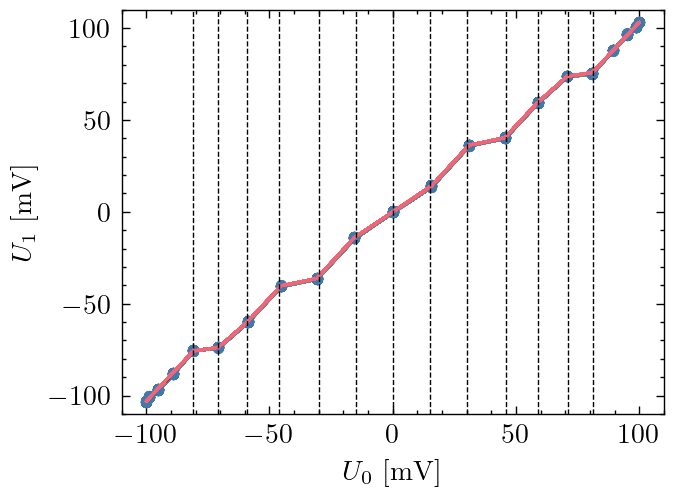

In [489]:
f0  = 0.001
x_v = U0_data[f0]*1000
y_v = data[f0]['Current'].values*1000
y_e = data[f0]['Error'].values*1000

knots       = np.array([-81, -71, -59, -46, -30, -15, 0, 15, 30, 46, 59, 71, 81])
Phi         = build_spline_features(x_v, knots)
theta, *_   = np.linalg.lstsq(Phi, y_v, rcond=None)
y_fit       = pwl_model(x_v, knots, theta)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(x_v,y_v, '.')
ax.plot(x_v,y_fit)
ax.fill_between(x_v,y_v-y_e,y_v+y_e,color='black',alpha=0.5)
ax.vlines(knots, -110, 110, ls='--', color='black', lw=0.5)
ax.set_xlabel("$U_0$ [mV]")
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlim(-110,110)
ax.set_ylim(-110,110)
ax.grid(False)

In [490]:
def f_static(u):
    return pwl_model(u, knots, theta)

### Extract Dynamic Part

In [575]:
def fundamental_freq_amplitude(signal, dt, f0):
    y       = signal - np.mean(signal)
    omega0  = 2*np.pi*f0*1e6
    N       = len(y)
    t       = np.arange(N) * dt
    Y1      = 2.0/N * np.sum(y * np.exp(-1j * omega0 * t))
    return Y1

G_hats  = []
last    = 1
for f0 in freq_vals[:-last]:
    x_v     = data[f0]['E0'].values*1000
    y_v     = data[f0]['Current'].values*1000
    Y_hat   = fundamental_freq_amplitude(y_v, dt_vals[f0], f0)
    U_hat   = fundamental_freq_amplitude(x_v, dt_vals[f0], f0)
    G_hat   = Y_hat / U_hat
    G_hats.append(G_hat)

G_hats = np.array(G_hats)
print(G_hats)

[ 1.00256106-2.13307205e-03j  1.00227953-4.20564276e-03j
  1.00161693-8.39635107e-03j  1.00103042-1.27788714e-02j
  1.00042606-1.69463096e-02j  0.99971432-2.12020519e-02j
  0.9959    -5.65623256e-02j  0.99074717-9.45308203e-02j
  0.97699968-1.47169483e-01j  0.94854006-2.21869048e-01j
  0.89215023-3.03596196e-01j  0.80314612-4.11921339e-01j
  0.62777806-5.09671701e-01j  0.27120446-5.29513237e-01j
  0.19483643-5.04464457e-01j  0.08851039-4.30565573e-01j
  0.0210481 -3.79575556e-01j -0.02107144-3.21205564e-01j
 -0.05573401-2.47551921e-01j -0.07461254-1.94398571e-01j
 -0.08606321-1.27668898e-01j -0.07854373-7.92972060e-02j
 -0.05314666-3.38907400e-02j -0.03337614-1.42738110e-02j
 -0.01830083-4.25000418e-03j -0.00962124-5.65839821e-04j
 -0.00431382+3.52111094e-04j -0.0021217 +2.86341967e-04j]


In [576]:
def G_model_complex_multi(omega, K, poles):
    """
    Complex FRF for an arbitrary number of stable poles:
      G(jω) = K / Π_i (1 + jω / p_i)
    
    Parameters
    ----------
    omega : array_like
        Angular frequencies (rad/s).
    K : float
        DC gain.
    poles : array_like
        Positive pole rates (rad/s), e.g. [p1, p2, p3, ...].
    
    Returns
    -------
    G : ndarray (complex)
        Complex G(jω) at each omega.
    """
    jw = 1j * omega[:, None]      # shape (len(omega), 1)
    poles = np.atleast_1d(poles)  # shape (n_poles,)
    # Denominator product over poles:
    denom = np.prod(1 + jw / poles, axis=1)
    return K / denom

def fit_complex_poles(omega, G_meas, n_poles, p0=None):
    """
    Fit K and n_poles positives p_i to measured complex FRF.
    
    Uses least-squares on real and imag parts.
    
    Parameters
    ----------
    omega : array_like
        Angular frequencies (rad/s).
    G_meas : array_like (complex)
        Measured complex G(jω).
    n_poles : int
        Number of poles to fit.
    p0 : array_like, optional
        Initial guess [K, p1, p2, ..., p_n].
        If None, K is set to |G_meas[0]|, poles spaced geometrically.
    
    Returns
    -------
    popt : ndarray
        Fitted parameters [K, p1, ..., p_n].
    pcov : None
        (placeholder, not computed).
    """
    # Initial guess
    if p0 is None:
        K0 = np.abs(G_meas[0])
        # geometric spacing between min and max omega
        w_min, w_max = omega.min(), omega.max()
        poles_guess = np.logspace(np.log10(w_min), np.log10(w_max), n_poles)
        p0 = np.concatenate(([K0], poles_guess))
    
    def residuals(params):
        K = params[0]
        poles = params[1:]
        G_pred = G_model_complex_multi(omega, K, poles)
        # stack real and imag errors
        return np.concatenate((G_pred.real - G_meas.real,
                               G_pred.imag - G_meas.imag))
    
    # Constrain K>0, poles>0
    lower = np.zeros(n_poles+1)
    upper = np.full(n_poles+1, np.inf)
    
    res = least_squares(residuals, p0, bounds=(lower, upper), max_nfev=10000)
    popt = res.x
    return popt, None

n_poles = 3
f0_MHz  = np.array(freq_vals)[:-last]
f0_Hz   = f0_MHz * 1e6
omega   = 2*np.pi * f0_Hz
popt, _ = fit_complex_poles(omega, G_hats, n_poles=n_poles)
K, *poles = popt
G_pred = G_model_complex_multi(omega, K, poles)

phase_hats = np.unwrap(np.angle(G_hats))
phase_pred = np.unwrap(np.angle(G_pred))

Text(0, 0.5, '$\\varphi$ [°]')

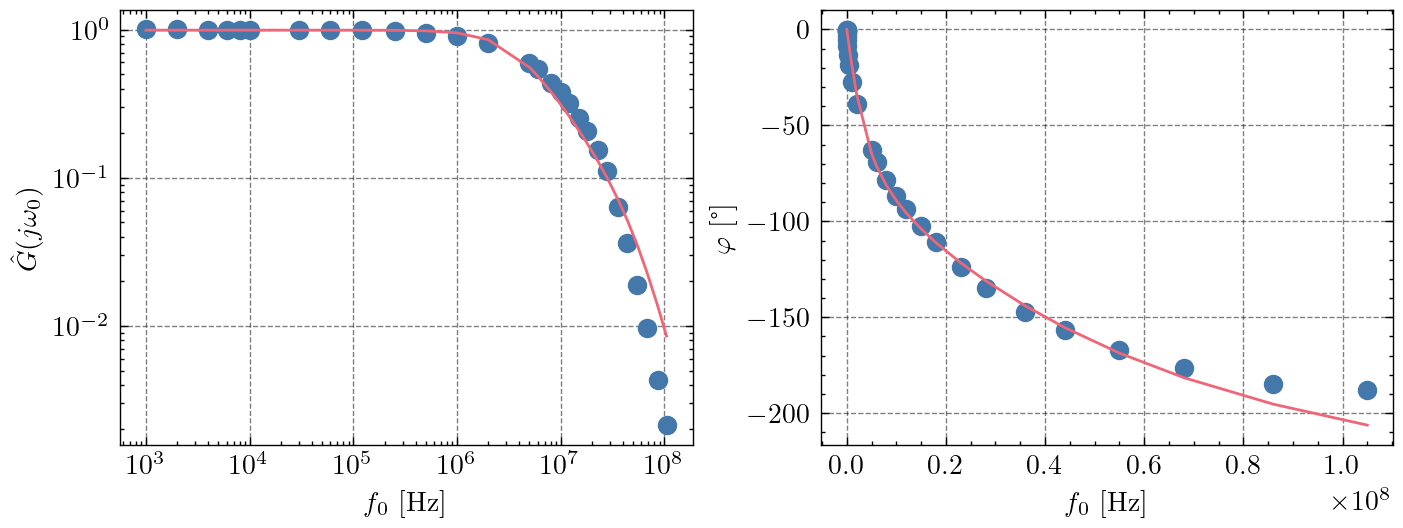

In [577]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2.0)
ax  = fig.add_subplot(1,2,1)
ax.plot(f0_Hz, np.abs(G_hats), 'o')
ax.plot(f0_Hz, np.abs(G_pred))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\hat{G}(j\omega_0)$")
ax.set_xlabel('$f_0$ [Hz]')
ax  = fig.add_subplot(1,2,2)
ax.plot(f0_Hz,np.degrees(phase_hats), 'o')
ax.plot(f0_Hz,np.degrees(phase_pred))
ax.set_xlabel('$f_0$ [Hz]')
ax.set_ylabel('$\\varphi$ [°]')

In [568]:
K, *poles     = popt
den           = np.poly([-p for p in poles])
num           = [K * np.prod(poles)]
G             = TransferFunction(num, den)

In [569]:
print("Numerator coeffs:", num)
print("Denominator coeffs:", den)
print("Poles (roots of denom):", np.roots(den))

Numerator coeffs: [np.float64(3.5377322954514767e+24)]
Denominator coeffs: [1.00000000e+00 8.37982360e+08 1.84172792e+17 3.56596516e+24]
Poles (roots of denom): [-4.08760927e+08 -4.07830589e+08 -2.13908442e+07]


In [571]:
f0  = 2.0
t_v = time_data[f0]/1e9
x_v = U0_data[f0]*1000
y_v = data[f0]['Current'].values*1000
y_e = data[f0]['Error'].values*1000

w           = f_static(x_v)
_, y_hat, _ = lsim(G, U=w, T=t_v)

(12499.999999999998, 14975.0)

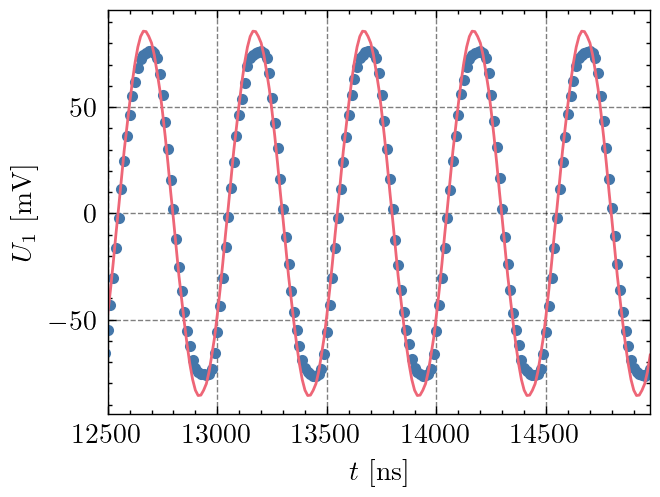

In [572]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_v*1e9, y_v, '.', label='$U_1$')
ax.plot(t_v*1e9, y_hat, label='Hammerstein fit')
ax.set_ylabel("$U_1$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax.set_xlim(t_v[1000]*1e9,np.max(t_v)*1e9)

---

Text(42.06756469338072, 0.5, '$j$')

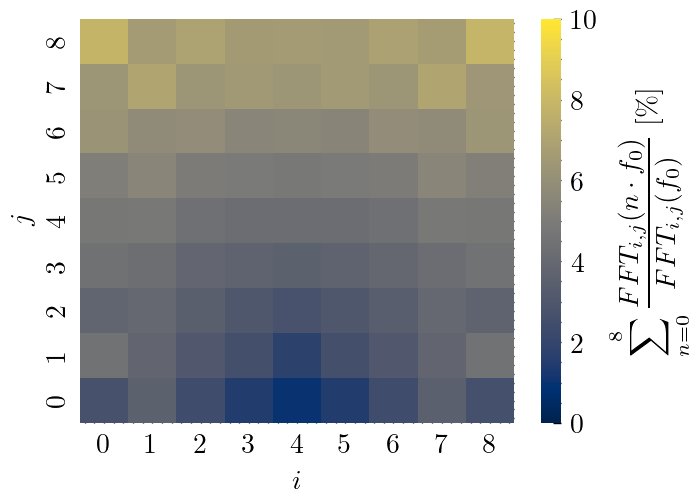

In [573]:
f0  = 5.0
val = thd_df.loc[f0,:].values.reshape(9,-1).copy()

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(val, cmap='cividis', ax=ax, vmin=0, vmax=10,
                  cbar_kws={"label":"$\displaystyle\sum_{n=0}^{8}\\frac{FFT_{i,j}(n \cdot f_0)}{FFT_{i,j}(f_0)}$ [\%]"})
ax.invert_yaxis()
ax.set_xlabel("$i$")
ax.set_ylabel("$j$")

In [ ]:
f0      = 5.0
val     = A_f0_df.loc[f0,:].values.reshape(9,-1).copy()
vmin    = int(val.min())
vmax    = int(val.max())

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(val, cmap='cividis', ax=ax, vmin=vmin, vmax=vmax,
                  cbar_kws={"label":""})
ax.invert_yaxis()
ax.set_xlabel("$i$")
ax.set_ylabel("$j$")

In [ ]:
val.min()

In [ ]:
f0      = 5.0
val     = pha_df.loc[f0,:].values.reshape(9,-1).copy()
val     = ((val+np.pi)%(2*np.pi)-np.pi)/np.pi

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(val, cmap='cividis', ax=ax, vmin=0, vmax=1,
                  cbar_kws={"label":""})
ax.invert_yaxis()
ax.set_xlabel("$i$")
ax.set_ylabel("$j$")

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(thd_df, cmap='cividis', ax=ax, vmin=0, vmax=10, # center=0, 
                  cbar_kws={"label":"$\displaystyle\sum_{n=0}^{8}\\frac{FFT_i(n \cdot f_0)}{FFT_i(f_0)}$ [\%]"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
fig.savefig("../plots/ac_input/2_electrodes/thd_phase.svg", transparent=True)

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(A_f0_df, cmap='cividis', ax=ax, #center=0,
                  cbar_kws={"label":"$FFT_i(f_0)$"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
# fig.savefig("../plots/ac_input/linear/Af0_vs_f0_vs_i.svg", transparent=True)

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(np.abs((pha_df+np.pi)%(2*np.pi)-np.pi)/np.pi, cmap='cividis', ax=ax, vmin=0, vmax=0.5, #center=0, 
                  cbar_kws={"label":"$|\\varphi|$ [$\pi$]"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
# fig.savefig("../plots/ac_input/linear/abs_phase_vs_f0_vs_i.svg", transparent=True)

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(((pha_df+np.pi)%(2*np.pi)-np.pi)/np.pi, cmap='cividis', ax=ax, vmin=-0.1, vmax=0.1, #center=0, 
                  cbar_kws={"label":"$\\varphi$ [$\pi$]"})
plt.yticks(rotation=0)
ax.set_ylabel("$f_0$ [MHz]")
ax.set_xlabel("$i$")
# fig.savefig("../plots/ac_input/linear/phase_vs_f0_vs_i.svg", transparent=True)

In [ ]:
A_f0_df.iloc[0,:]

In [ ]:
lam     = []
params  = []
for i in range(len(A_f0_df)):
    p,_ = curve_fit(exp_decay, np.arange(39), A_f0_df.iloc[i,:-1].values, bounds=([0,0,0],[np.inf,np.inf,np.inf]))
    lam.append(p[1])
    params.append(p)

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(np.array(freq_vals)/1e6, lam, 'o-')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$\lambda$ [$N_{NP}$]")
ax.set_ylim(10,22)
fig.savefig("../plots/ac_input/linear/penetration_depth_vs_f0.svg", transparent=True)

$1 / \tau = 2$ MHz

In [ ]:
p_df    = pot_data[2e6].copy()


In [ ]:
sim_class           = nanonets.simulation(topology_parameter=topology_parameter, high_C_output=False)
cap_matrix          = sim_class.capacitance_matrix
inv_cap_matrix      = sim_class.inv_capacitance_matrix

In [ ]:
f0  = 2e6
Q_t = np.zeros_like(pot_data[f0].values)
C   = cap_matrix
C_i = inv_cap_matrix
for t in range(pot_data[f0].values.shape[0]):
    Q_t[t, :] = C @ pot_data[f0].values[t, :]

# Total injected charge (relative to t=0)
Q_total = np.sum(Q_t - Q_t[0, :], axis=1)  # Shape: (N_T,)
P       = Q_t[-1, 1:] - Q_t[-1, :-1]

E_t = np.zeros(pot_data[f0].values.shape[0])
for t in range(pot_data[f0].values.shape[0]):
    E_t[t] = 0.5 * Q_t[t, :].T @ C_i @ Q_t[t, :]

In [ ]:
plt.plot(np.diff(Q_t[:,5]))

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(P)
ax.set_xlabel("$i$")
ax.set_ylabel("$P_i$")

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(time_data[f0],Q_total)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$Q_{total}$ [C]")

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(time_data[f0],E_t)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$E$ [J]")

In [ ]:
idx = [9,19,29,39]
idx = [38]
f0  = 1e6

for i in idx:

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    t   = time_data[f0]
    y   = pot_data[f0].iloc[:,i].values.copy()*1000

    ax.plot(t*1e9, y)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$\phi_{"+f"{i}"+"}$ [mV]")
    # ax.set_xlim(0,1000)

In [ ]:
f0  = 5e6
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
t   = time_data[f0]
y   = data[f0].loc[:,'Current'].values.copy()
y_e = data[f0].loc[:,'Error'].values.copy()

ax.plot(t*1e9, y)
ax.fill_between(t*1e9, y-y_e, y+y_e, color='black', alpha=0.2)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$I$ [pA]")
ax.set_xlim(0,3000)

In [ ]:
plt.imshow(thd_df)

In [ ]:
idx = [0,9,20,30,39]
f0  = 10e6
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for i in idx:
    y   = pot_data[f0].iloc[:,i].values.copy()/U0
    t   = np.arange(len(y))*time_step
    ax.plot(sin_func(t, U0, f0, 0, 0)/U0, y)
ax.set_xlabel("$U_0(t)/U_0$")
ax.set_ylabel("$\phi_i(t)/U_0$")

In [ ]:
for f0 in f_vals:

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    t_val   = t_vals.copy() 
    x_val   = data_string[f0]['E0'].values[-10000:]*1000
    y_val   = data_string[f0]['Current'].values[-10000:]*1000
    y_err   = data_string[f0]['Error'].values[-10000:]*1000
    ax.plot(x_val, y_val)
    ax.fill_between(x_val, y_val-y_err, y_val+y_err, alpha=0.2, color='black')
    ax.set_xlabel("$U_0$ [mV]", fontsize='x-large')
    ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')

    fig.savefig(f"../plots/ac_input/phase_space/{f0}.svg", transparent=True)
    fig.savefig(f"../plots/ac_input/phase_space/{f0}.pdf", transparent=False)
    plt.close(fig)

In [ ]:
for f0 in f_vals:

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    t_val   = t_vals[f0].copy()
    x_val   = data_string[f0]['E0'].values[-10000:]*1000
    y_val   = data_string[f0]['Current'].values[-10000:]*1000
    y_err   = data_string[f0]['Error'].values[-10000:]*1000
    ax.plot(t_val, y_val)
    ax.fill_between(t_val, y_val-y_err, y_val+y_err, alpha=0.2, color='black')
    ax.set_xlabel("$U_0$ [mV]", fontsize='x-large')
    ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')

    fig.savefig(f"../plots/ac_input/signal/{f0}.svg", transparent=True)
    fig.savefig(f"../plots/ac_input/signal/{f0}.pdf", transparent=False)
    plt.close(fig)

In [ ]:
for f0 in f_vals:

    t_val   = t_vals[f0].copy()
    x_val   = data_string[f0]['E0'].values*1000
    y_val   = data_string[f0]['Current'].values*1000
    y_val   = y_val-np.mean(y_val)
    t_step  = time_step[f0]
    xf, yf  = nanonets_utils.fft(signal=y_val, dt=t_step, n_padded=16384)
    xf      = xf / 1e6
    y_min   = 1e-3
    y_max   = 1e4

    fig = plt.figure(dpi=250)
    ax  = fig.add_subplot()
    ax.plot(xf, yf)

    ax.set_yscale('log')
    ax.set_xlim(0,20*f0)
    ax.set_ylim(y_min,y_max)
    ax.set_xlabel("$f$ [MHz]", fontsize='x-large')
    ax.set_ylabel("$FFT$", fontsize='x-large')
    # ax.legend(fontsize='xx-small', loc='upper right', ncol=3)
    fig.savefig(f"../plots/ac_input/fft/{f0}.svg", transparent=True)
    plt.close(fig)

In [ ]:
N_f         = 50
h_strength  = []
end         = 5

for f0 in freq_vals[:-end]:
    y_val   = data_string[f0]['Current'].values*1000
    t_step  = time_step[f0]
    h_temp  = nanonets_utils.harmonic_strength(signal=y_val, f0=f0*1e6, dt=t_step, N_f=N_f, n_padded=16384, dB=False)
    h_strength.append(h_temp)

h_df    = pd.DataFrame(h_strength, columns=np.arange(2,N_f+2), index=f_vals[:-end])
thd_v   = np.sqrt(np.sum(np.array(h_strength)**2, axis=1))*100
h_df

In [ ]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax  = sns.heatmap(h_df, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$"}, vmin=0, vmax=0.1)
ax.set_ylabel('$f_0$ [MHz]', fontsize='x-large')
ax.set_xlabel("$n$", fontsize='x-large')
plt.yticks(rotation=0)
fig.savefig(f"../plots/harmonic_strength.svg", transparent=True)

In [ ]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax.plot(f_vals[:-end], thd_v, '.-')
ax.set_ylabel('$THD$ [\%]', fontsize='x-large')
ax.set_xlabel('$f_0$ [MHz]', fontsize='x-large')
ax.set_xscale('log')
ax.set_xlim(1e-3,1e2)
ax.set_ylim(0,12)
fig.savefig(f"../plots/thd.svg", transparent=True)

In [ ]:
phis    = []
params  = []
for f0 in f_vals[:-end]:
    t       = t_vals[f0]
    y       = data_string[f0]['Current'].values.copy()
    p, cov  = curve_fit(sin_func, t, y, p0=[0.1,f0*1e6,0,0])
    params.append(p)
    phis.append(p[2])

In [ ]:
i   = 10
plt.plot(t_vals[f_vals[i]], sin_func(t_vals[f_vals[i]],*params[i]))
plt.plot(t_vals[f_vals[i]], data_string[f_vals[i]]['Current'].values)

In [ ]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax.plot(f_vals[:-end], phis, 'o-')
ax.set_xscale('log')
ax.set_xlabel('$f_0$ [MHz]')
ax.set_ylabel('$\phi$ [rad]')

---

In [ ]:
N_samples   = 100
eq_steps    = 10000
time_step   = 1e-10
folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/frequency_modulation/"
dic_sample  = {i : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{i}.csv").iloc[eq_steps:,:].reset_index(drop=True) for i in range(N_samples)}
time_vals   = np.arange(len(dic_sample[0]))*time_step

In [ ]:
phis    = []
t       = time_vals.copy()
for key, df in dic_sample.items():
    y       = df['Current'].values.copy()
    p, cov  = curve_fit(sin_func, t, y, p0=[0.1,3.5e6,0,0])
    phis.append(p[2])

In [ ]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax  = sns.histplot(phis, stat='density')

ax.set_xlabel("$\phi$", fontsize='x-large')
ax.set_ylabel("$Density$", fontsize='x-large')

fig.savefig(f"../plots/phase_shift.svg", transparent=True)

In [ ]:
plt.plot(time_vals, y)
plt.plot(time_vals, sin_func(time_vals,*p))

In [ ]:
f0  = 3.5*1e6
n_p = 100000
N_f = 5
yff = []
hss = []

for i in range(N_samples):

    y       = dic_sample[i]['Current'].values*1000
    y       = y - np.mean(y)
    xf, yf  = nanonets_utils.fft(signal=y, dt=time_step, n_padded=n_p)
    hs      = nanonets_utils.harmonic_strength(signal=y, f0=f0, dt=time_step, N_f=N_f, n_padded=n_p)
    yff.append(yf)
    hss.append(hs)

h_strength_sample   = pd.DataFrame(hss, columns=np.arange(2,N_f+2))
thd_sample          = np.sqrt(np.sum(np.array(hss)**2, axis=1))
min_sample          = np.argsort(thd_sample)[0]
max_sample          = np.argsort(thd_sample)[-1]
h_strength_sample

In [ ]:
y_min   = 5e1
y_max   = 1e5

fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax.plot(xf/1e6, yff[min_sample])

ax.set_xlim(0,11*f0/1e6)
ax.set_yscale('log')
ax.set_ylim(y_min,y_max)
ax.set_xlabel("$f$ [MHz]", fontsize='x-large')
ax.set_ylabel("$FFT$", fontsize='x-large')

fig.savefig(f"../plots/fft_min_sample.svg", transparent=True)

In [ ]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax.plot(xf/1e6, yff[max_sample])

ax.set_xlim(0,11*f0/1e6)
ax.set_yscale('log')
ax.set_ylim(y_min,y_max)
ax.set_xlabel("$f$ [MHz]", fontsize='x-large')
ax.set_ylabel("$FFT$", fontsize='x-large')

fig.savefig(f"../plots/fft_max_sample.svg", transparent=True)

In [ ]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
df  = dic_sample[min_sample].iloc[20000:]
ax.plot(df['E0']*1000, df['Current']*1000)
ax.set_xlim(-100,100)
ax.set_xlabel('$U_0(t)$ [mV]', fontsize='x-large')
ax.set_ylabel('$U_7(t)$ [mV]', fontsize='x-large')

# ax.set_xlim(0,11*f0/1e6)
# ax.set_yscale('log')
# ax.set_ylim(y_min,y_max)
# ax.set_xlabel("$f$ [MHz]", fontsize='x-large')
# ax.set_ylabel("$FFT$", fontsize='x-large')

# fig.savefig(f"../plots/phase_space_sample_1.svg", transparent=True)

In [ ]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
df  = dic_sample[max_sample].iloc[20000:]
ax.plot(df['E0']*1000, df['Current']*1000)
ax.set_xlim(-100,100)
ax.set_xlabel('$U_0(t)$ [mV]', fontsize='x-large')
ax.set_ylabel('$U_7(t)$ [mV]', fontsize='x-large')

# fig.savefig(f"../plots/phase_space_sample_2.svg", transparent=True)

In [ ]:
i = max_sample

fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
df  = dic_sample[i].iloc[20000:]
# ax.plot(t_vals[20000:], df['Current']*1000)
ax.plot(df['Current']*1000)
ax.set_xlabel('$t$ [mV]', fontsize='x-large')
ax.set_ylabel('$U_7(t)$ [mV]', fontsize='x-large')

# fig.savefig(f"../plots/phase_space_sample_2.svg", transparent=True)

---

In [ ]:
fig = plt.figure(dpi=250)
ax  = fig.add_subplot()
ax  = sns.heatmap(h_strength_sample.iloc[np.argsort(thd_sample),:].reset_index(drop=True).T, cmap='Reds', cbar_kws={"label":"$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$"}, vmin=0, vmax=0.2)
ax.set_xlabel('$Sample$')
ax.set_ylabel("$n$")
plt.yticks(rotation=0)
fig.savefig(f"../plots/harmonic_strength_sample.svg", transparent=True)

---

In [ ]:
# Global
N_voltages  = 50000
N_samples   = 500
time_step   = 1e-10
stat_size   = 100
time_steps  = np.arange(N_voltages)*time_step
folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/frequency_modulation/"
# folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/frequency_modulation/"

N_p                 = 9
topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : N_p,
        "Nz"                : 1,
        "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],
                            [0,(N_p-1)//2,0],[N_p-1,(N_p-1)//2,0],
                            [0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
        "electrode_type"    : ['constant','constant','constant','constant',
                            'constant','constant','constant','constant']
}

# String
frequencies     = [3.5*1e6,0,0,0,0,0,0,0]
amplitudes      = [0.1,0,0,0,0,0,0,0]
offsets         = np.round(np.random.uniform(-0.1,0.1,(N_samples,8)),4)
offsets[:,0]    = 0.0
offsets[:,-1]   = 0.0
N_processes     = 10
procs           = []

offset              = offsets[0,:]
time_steps, volt    = nanonets_utils.sinusoidal_voltages(N_voltages, topology_parameter, amplitudes=amplitudes, frequencies=frequencies, time_step=time_step, offset=offset)

In [ ]:
sim_class   = nanonets.simulation(topology_parameter, high_C_output=False)


fig, ax     = plt.subplots(dpi=200)
fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=80)

fig.savefig("../plots/network.svg", transparent=True, bbox_inches='tight')